# Chapter09 비지도 학습

In [59]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [66]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### 9.1 군집

군집 (clustering) :

샘플들을 비슷한 샘플의 그룹(클러스터)으로 할당하는 비지도 학습 

- k-평균 : 

 각 클러스터의 중심을 찾고 가장 가까운 클러스터에 샘플을 할당한다.

In [143]:
# 클러스팅 용 가상 데이터 생성
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)
y

array([4, 2, 0, ..., 3, 0, 2])

In [3]:
# 클러스터 데이터셋 그리는 메서드 정의
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

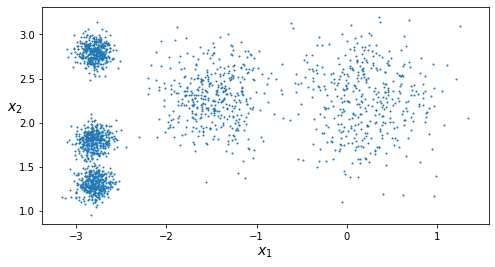

In [4]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [5]:
# k-평균 알고리즘 훈련 및 예측
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k)   # n_clusters: 알고리즘이 찾을 클러스트 개수
y_pred = kmeans.fit_predict(X)
y_pred

array([2, 4, 1, ..., 0, 1, 4], dtype=int32)

In [6]:
kmeans.labels_  # 훈련된 샘플의 레이블이 저장되어 있음

array([2, 4, 1, ..., 0, 1, 4], dtype=int32)

In [7]:
y_pred is kmeans.labels_

True

In [8]:
kmeans.cluster_centers_  # KMeans가 찾은 각 클러스터별 센트로이드

array([[-2.79290307,  2.79641063],
       [ 0.20876306,  2.25551336],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

In [9]:
# 새로운 샘플 예측
X_new = np.array([[0,2], [3,2], [-3,3], [-3,2.5]])
kmeans.predict(X_new)

array([1, 1, 0, 0], dtype=int32)

In [10]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=35, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

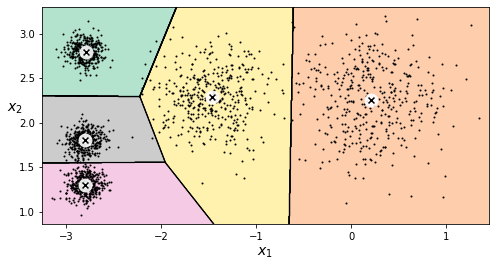

In [11]:
# 결정경계 그리기 (보로노이 다이어그램)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

위 그림을 보면, 클러스터의 크기가 달라서 샘플 몇 개는 레이블이 잘못 부여되었다.. (하드 군집)

- 하드 군집 :

 샘플을 하나의 클러스터에 할당하는 것

- 소프트 군집 :
 
 클러스터마다 샘플에 점수를 부여하는 것

In [12]:
kmeans.transform(X_new)  # 샘플과 각 센트로이드 사이의 거리를 반환

array([[2.9042344 , 0.32995317, 2.88633901, 1.49439034, 2.81093633],
       [5.84739223, 2.80290755, 5.84236351, 4.4759332 , 5.80730058],
       [0.29040966, 3.29399768, 1.71086031, 1.69136631, 1.21475352],
       [0.36159148, 3.21806371, 1.21567622, 1.54808703, 0.72581411]])

k-평균 알고리즘 :

1. 처음에는 센트로이드를 랜덤하게 초기화

2. 각 샘플을 가장 가까운 센트로이드에 할당

3. 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트합니다.

4. 센트로이드 업데이트 변화가 없을 때까지 2~3 반복

목적함수 $J = \sum\limits_{n=1}^{K} \sum\limits_{n=1}^{K}r_{nk} || \mathbf{x}_n - \mu_k||^2$ 를 최소화 될 때까지 반복

In [13]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

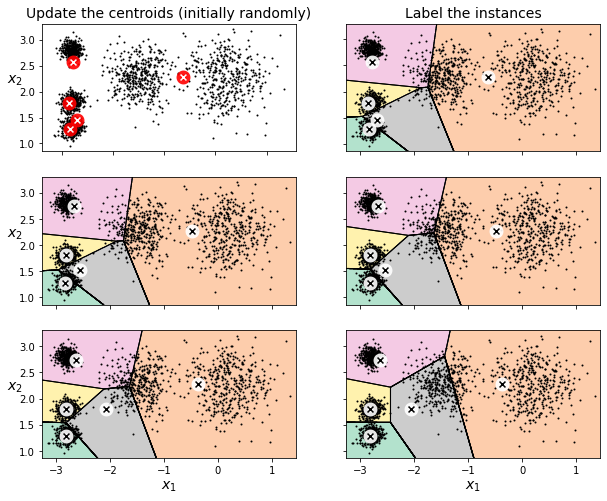

In [14]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

In [15]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

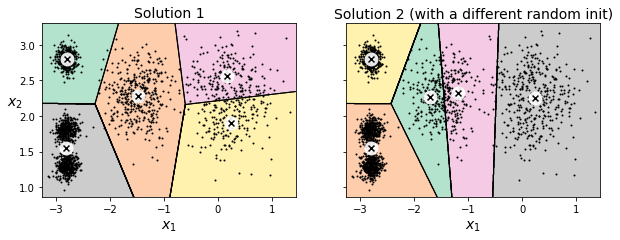

In [16]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

운 나쁜 센트로이드 초기화 때문에 만들어진 나쁜 군집 예

- 센트로이드 초기화 방법 : 

 1. 먼저 실행한 또 다른 군집 알고리즘의 센트로이드로 초기화하기

 2. 랜덤 초기화를 다르게 하여 여러 번 알고리즘을 실행하고 가장 좋은 솔루션 선택하기

 3. k-평균++ 초기화

In [17]:
# 1번 방법
good_init = np.array([[-3,3],[-3,2],[-3,1],[-1,2],[0,2]])

# 1번 + 2번 방법
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)   # n_init: 랜덤 초기화 횟수 (default:10)
kmeans.fit_predict(X)

array([2, 1, 4, ..., 0, 4, 1], dtype=int32)

- 이너서 (inertia) : 가장 좋은 솔루션을 선택할 수 있는 성능 지표

 : 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리

- KMeans는 n_init번 실행하여 '이너셔'가 가장 낮은 모델을 반환한다.

In [18]:
kmeans.inertia_   # 모델의 이너셔 반환

211.5985372581684

In [19]:
kmeans.score(X)  # score()메서드는 이너셔의 음수값을 반환

-211.59853725816856

- k-평균++ 알고리즘 :

 다른 센트로이드와 거리가 먼 센트로이드를 선택하는 초기화 단계를 가짐

 1. 데이터셋에서 무작위로 균등하게 하나의 센트로이드 $c_1$을 선택합니다.

 2. $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$의 확률로 샘플 $\mathbf{x}_i$를 새로운 센트로이드 $c_i$로 선택
 
   - $D(\mathbf{x}_i)$ : 샘플 $\mathbf{x}_i$에서 이미 선택된 가장 가까운 센트로이드까지 거리

 3. $k$ 개의 센트로이드를 선택할 때까지 이전 단계를 반복

KMeans 클래스가 기본적으로 이 초기화 방법을 사용

반복 횟수도 줄여주어서 속도도 빠를 것이다.

- **k-평균 속도 개선**

 1. 삼각부등식 사용 :
  
   임의의 두 레코드 건 거리는 다른 두 쌍의 레코드 간 거리의 합 보다 클 수 없음 ......?

 2. 미니배치 k-평균 :

   전체 데이터셋을 사용해 반복하지 않고 각 반복마다 미니배치를 사용해 센트로이드를 조금씩 이동한다.

   메모리에 들어가지 않는 대량의 데이터셋에 군집 알고리즘을 적용할 수 있다.

In [20]:
# 사이킷런의 미니배치 k-평균
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [21]:
minibatch_kmeans.inertia_

212.55531852986118

- 미니배치 k-평균 :

 일반 k-평균 알고리즘보다 훨씬 빠르지만, 이너셔는 일반적으로 조금 더 나쁘다. (특히 클러스터 개수가 증가할 때 더 그렇다)

In [22]:
# MNIST 데이터셋 로드하기
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [23]:
# 테스트세트 나누고
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], random_state=42)

In [24]:
# memmap에 데이터 기록
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [25]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

데이터가 너무 커서 memmap를 사용할 수 없는 경우

In [26]:
# 배치를 로드하는 함수 (실전에서는 디스크에서 데이터 로드)
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]   # replace=False: 중복추출 허용X

In [37]:
np.random.choice(10, 5, replace=False)   # 중복을 허용하지 않고 무작위로 추출

array([5, 3, 4, 2, 9])


한 번에 하나의 배치를 모델에 주입하여 훈련한다. 

또한 여러 번 초기화를 수행하고 이너셔가 가장 낮은 모델을 선택한다.

In [27]:
np.random.seed(42)

In [28]:
k = 5               # 클러스터 개수
n_init = 10         # 초기화 횟수
n_iterations = 100  # 반복 횟수
batch_size = 100    # 배치 크기
init_size = 500     # K-Means++ 초기화를 위해 충분한 데이터 전달
evaluate_on_last_n_iters = 10  # 마지막에서 10번째 반복부터 평가하겠다..

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)   # 배치크기만큼 배치 뽑고
        minibatch_kmeans.partial_fit(X_batch)   # partial_fit() 해주기
        if iteration >= n_iterations - evaluate_on_last_n_iters:    # 평가해주는 단계 (마지막에서 10번째 반복이라면)
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_  # 이너셔로 평가

    if (best_kmeans is None or minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):   # best model 찾기 (이너셔가 가장 작은걸로)
        best_kmeans = minibatch_kmeans

In [29]:
best_kmeans.score(X)

-211.70999744411483

In [38]:
# 일반 k-평균
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

10 loops, best of 5: 44.1 ms per loop


In [39]:
# 미니배치 k-평균
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

10 loops, best of 5: 23.7 ms per loop


미니배치 k-평균이 더 빠르다.

In [30]:
from timeit import timeit

times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

미니배치 k-평균의 이너셔가 k-평균보다 조금 높지만, 훨씬 빠르고 k가 커짐에 따라서 더 빠르다.

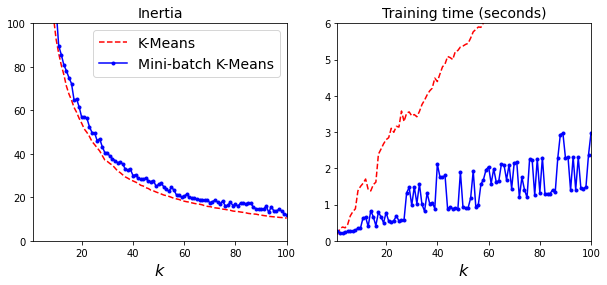

In [32]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

- 최적의 클러스터 개수 찾기

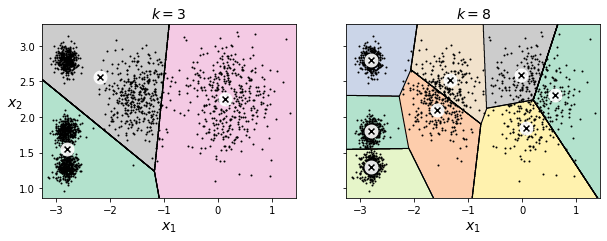

In [43]:
# 잘못된 클러스터 개수 지정
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [44]:
kmeans_k3.inertia_

653.2167190021553

In [45]:
kmeans_k8.inertia_

118.41983763508077

8개가 최적의 개수는 아니지만, 최적의 클러스터 개수 (5개) 일때보다 이너셔가 더 낮다 --> 이너셔로 최적의 개수를 판단하면 안된다!

In [46]:
# n_cluster의 개수에 따른 이너셔 계산

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

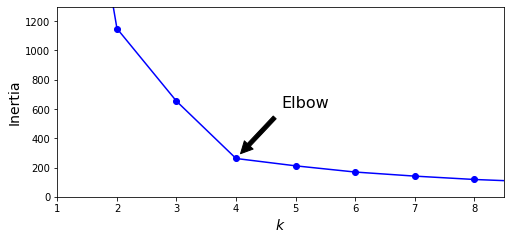

In [47]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

확 꺽이는 지점 '엘보(Elbow)'이 최선의 클러스터 개수로 선택할 수 있다. (뭔가 애매)

더 정확한 방법 :

- 실루엣 점수 == 모든 샘플에 대한 실루엣 계수의 평균

 - 실루엣 계수 : $(b-a)\, /\, max(a,\, b)$
  
   - $a$ : 클러스터 내부의 평균 거리

   - $b$ : 가장 가까운 클러스터의 샘플까지 평균 거리

   -1 < 실루엣 계수 < +1

  - +1 에 가까우면 자신의 클러스터 안에 잘 속해있고, 다른 클러스터와는 멀리 떨어져 있다.

  - 0 에 가까우면 클러스터 경계에 위치한다는 의미, 

  - -1 에 가까우면 이 샘플이 잘못된 클러스터에 할당되었다는 의미

In [48]:
# 사이킷런 내장 함수로 실루엣 점수를 계산

from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)  # 모든 샘플과 할당된 레이블 전달

0.655517642572828

In [56]:
# k에 따른 실루엣 점수 계산

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]
# n_cluster가 1이면 b를 계산 못하니까 kmeans_per_k[1:] (n_cluster=2부터 계산)

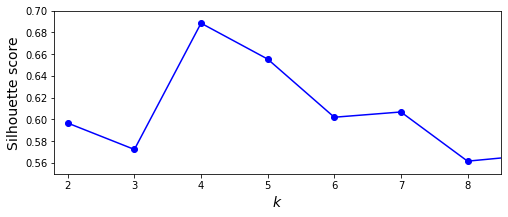

In [57]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

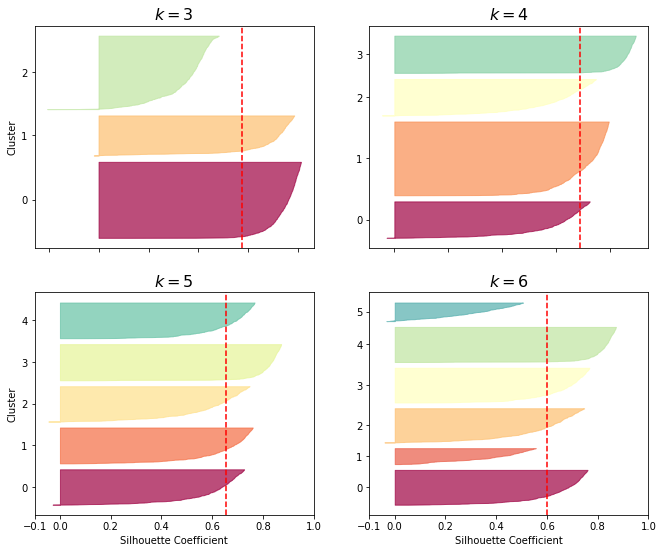

In [60]:
# 실루엣 다이어그램 그리기 (모든 샘플의 실루엣 계수를 할당된 클러스터와 
#                           계숫값으로 정렬하여 그려서 더 많은 정보가 있는 그래프를 얻을 수 있다)

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

- 그래프의 높이 : 클러스터가 포함하고 있는 샘플의 개수를 의미

- 그래프의 너비 : 이 클러스터에 포함된 샘플의 정렬된 실루엣 계수를 나타냄 (넓을수록 좋음)

- 수직 파선 : 각 클러스터 개수에 해당하는 실루엣 점수를 나타냄

 수직 파선 왼쪽에서 멈추는 샘플들이 적을수록 좋은 클러스터이다.

 (k=3 or k=6)에서 나쁜 클러스터를 볼 수 있고, (k=4 or k=5)의 클러스터가 상당히 좋아보인다.

k=4일 때 3번째 클러스터가 매우 커서, 전반적인 실루엣 점수가 k=5일 때보다 더 높더라도

비슷한 크기의 클러스터를 얻을 수 있는 k=5를 선택하는 것이 좋다.

In [62]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [63]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

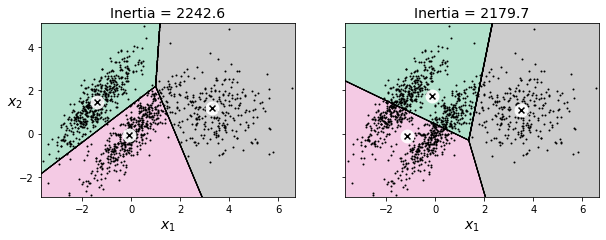

In [64]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

plt.show()

k-평균이 속도가 빠르고 확장이 용이하지만, 

1. 여러 번 실행해야 최적의 솔루션을 찾을 수 있고,

2. 클러스터 개수를 지정해야 하며,

3. 클러스터 크기나 밀집도가 다르거나 원형이 아닐 경우 잘 작동하지 않는다.

 k-평균을 실행하기 전에 입력 특성의 스케일을 맞추는 것이 중요!

 (*위 그림처럼 타원형 클러스에서는 가우시안 혼합 모델이 잘 작동한다)
---

- 이미지 분할 (image segmentation):

 이미지를 세그먼트 여러 개로 분할하는 작업

- 시멘틱 분할 : 

 동일한 종류의 물체에 속한 모든 픽셀은 같은 세그먼트에 할당

 - 색상 분할 : 동일한 색상을 가진 픽셀을 같은 세그먼트에 할당

In [67]:
# 무당벌레 이미지를 다운로드
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fb8c0e3bf90>)

In [68]:
from matplotlib.image import imread

image = imread(os.path.join(images_path, filename))
image.shape  # (높이, 너비, 채널 개수)

(533, 800, 3)

In [88]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [90]:
# 다양한 클러스터 개수로 k-평균을 사용해 이미지 분할하기

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

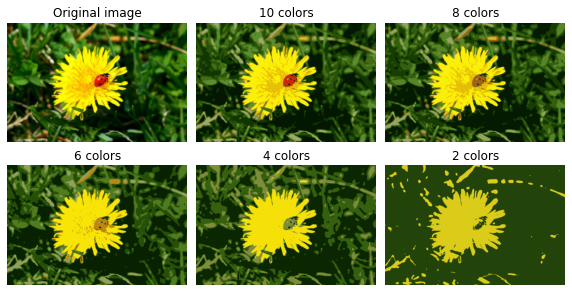

In [91]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

- 군집을 사용한 전처리

 군집은 차원축소에 효과적인 방법으로, 지도 학습에 적용하기 전 전처리 단계로 사용 가능

In [92]:
# MNIST와 비슷한 숫자 데이터셋 (8x8 크기 흑백이미지 1797개)
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [103]:
# 테스트세트 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [112]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [113]:
# 테스트세트로 평가
log_reg.score(X_test, y_test)

0.9644444444444444

군집을 사용해서 데이터 전처리 후 훈련을 해보자.

In [114]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),  # 군집을 사용한 전처리
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [115]:
pipeline.score(X_test, y_test)

0.9844444444444445

전처리 (군집)을 하고 훈련을 하니 오차율이 줄었다!

더 줄여보자 (최적의 k 찾기)

In [120]:
# 최적의 k를 찾기 위한 그리드서치
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(98, 100))  # '{모델이름}__{탐색할 변수명}' <-- 전달
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                   

In [121]:
grid_clf.best_params_

{'kmeans__n_clusters': 98}

In [123]:
grid_clf.score(X_test, y_test)

0.9844444444444445

- 군집을 사용한 준지도 학습 :

 레이블이 없는 데이터가 많고 레이블이 있는 데이터는 적을 때 사용

In [ ]:
# 레이블을 가진 샘플이 50개일 때
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

In [127]:
log_reg.score(X_test, y_test)

0.8577777777777778

In [152]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)   # 각 센트로이드까지의 거리 반환
print(f"X_digits_dist.shape: {X_digits_dist.shape}")
representative_digit_idx = np.argmin(X_digits_dist, axis=0) # 각 클러스터에서 센트로이드에 가장 가까운 이미지 (대표 이미지)
X_representative_digits = X_train[representative_digit_idx]

X_digits_dist.shape: (1347, 50)


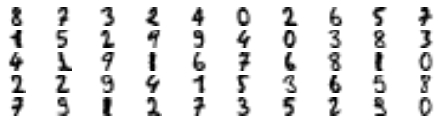

In [137]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [158]:
y_train[representative_digit_idx]   # 대표 이미지

array([8, 7, 3, 2, 4, 0, 2, 6, 5, 7, 1, 5, 2, 9, 9, 4, 0, 3, 8, 3, 4, 1,
       9, 1, 6, 7, 6, 8, 1, 0, 2, 2, 9, 4, 1, 5, 3, 6, 5, 8, 7, 9, 1, 2,
       7, 3, 5, 2, 9, 0])

In [160]:
# 이미지를 보고 수동으로 레이블 할당

y_representative_digits = np.array([8, 7, 3, 2, 4, 0, 2, 6, 5, 7,
                                   1, 5, 2, 9, 9, 4, 0, 3, 8, 3,
                                   4, 1, 9, 1, 6, 7, 6, 8, 1, 0,
                                   2, 2, 9, 4, 1, 5, 3, 6, 5, 8,
                                   7, 9, 1, 2, 7, 3, 5, 2, 9, 0])

이제 레이블된 50개 샘플로 이루어진 데이터셋이 준비되었다.

In [161]:
# 모델 훈련 후 평가
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9377777777777778

성능이 확실히 좋아졌다!

- 레이블 전파 : 이 레이블을 같은 클러스터에 있는 다른 모든 샘플에 전파하면 어떨까?

In [162]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)  # 초기화되지 않은 값 생성 (쓰레기값 들어가있음)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [185]:
pd.DataFrame(y_train_propagated).value_counts()

1    158
2    156
9    149
0    144
6    137
5    132
3    127
7    126
4    112
8    106
dtype: int64

In [187]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [188]:
log_reg.score(X_test, y_test)

0.9333333333333333

ㅋ